# Powertrain for UAV

In [141]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import gym
from systems.powertrain import *
np.random.seed(43)

### The Continuous Battery Cell
- predefined curves must be derived emperically 

In [142]:
# load the battery curves
battery_coefficients = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')

# create the battery cell
cbcell = ContinuousBatteryCell(**battery_coefficients)

### plot the battery profile curves
- q degradation
- r0 degradation
- soc ocv curve

4.052408561253653
0.013503516031979206
3.865514026190776


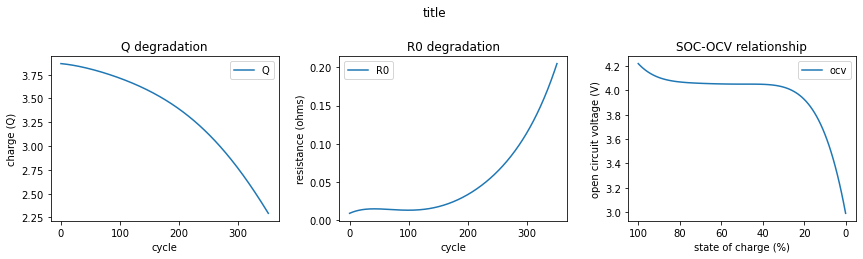

In [139]:
# shows that profile curves are continuous
print(cbcell.get_v(z=45.32434))
print(cbcell.get_r0(age=123.232))
print(cbcell.get_q(age=.973))

plot_q = np.array([np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol))])
plot_r = np.array([np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol))])
plot_z = np.array([np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101))])

three_plot(plot1=plot_q, plot2=plot_r, plot3=plot_z, 
           label1=["Q"], label2=["R0"], label3=["ocv"], 
           title1="Q degradation", title2="R0 degradation", title3="SOC-OCV relationship",
           axes1=["cycle", "charge (Q)"], axes2=["cycle", "resistance (ohms)"], axes3=["state of charge (%)", "open circuit voltage (V)"],
           invert=[0,0,1], save=True, filename="figures/battery_profile_curves.png")

### EOD simulation

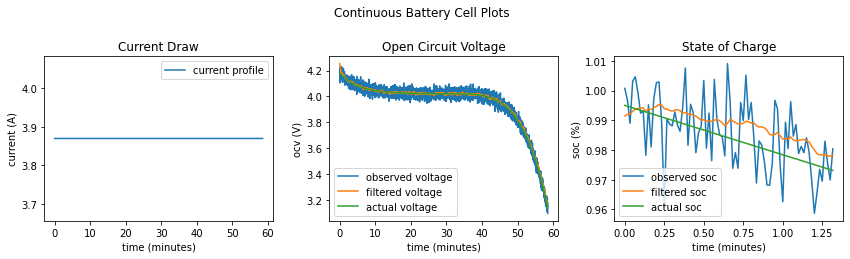

In [126]:
# simulate until EOD
cycle_test(cell=cbcell, random_load=False, verbose=0, show_plot=True, reset=False, action=1)#, save_plot=True, file_name="figures/continuous_cell_test2.png")

### Charging simulation

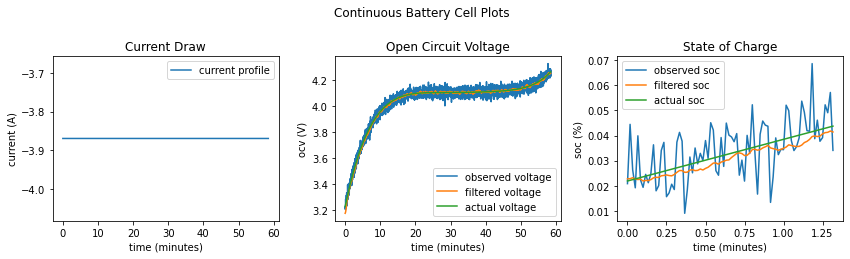

In [127]:
cycle_test(cell=cbcell, random_load=False, verbose=0, show_plot=True, reset=False, action=0)#, save_plot=True, file_name="figures/continuous_cell_charging.png")

### EOL simulation

run: 1	Q: 3.869	R0: 0.011	avg_load: 3.870	cycle_time: 3527	age: 0.933	eol: 352
run: 2	Q: 3.866	R0: 0.011	avg_load: 3.870	cycle_time: 3524	age: 1.866	eol: 352
run: 3	Q: 3.865	R0: 0.011	avg_load: 3.870	cycle_time: 3523	age: 2.799	eol: 352
run: 4	Q: 3.864	R0: 0.011	avg_load: 3.870	cycle_time: 3523	age: 3.733	eol: 352
run: 5	Q: 3.864	R0: 0.011	avg_load: 3.870	cycle_time: 3522	age: 4.667	eol: 352
run: 6	Q: 3.863	R0: 0.011	avg_load: 3.870	cycle_time: 3521	age: 5.601	eol: 352
run: 7	Q: 3.862	R0: 0.011	avg_load: 3.870	cycle_time: 3521	age: 6.535	eol: 352
run: 8	Q: 3.862	R0: 0.011	avg_load: 3.870	cycle_time: 3520	age: 7.470	eol: 352
run: 9	Q: 3.861	R0: 0.011	avg_load: 3.870	cycle_time: 3520	age: 8.404	eol: 352
run: 10	Q: 3.860	R0: 0.011	avg_load: 3.870	cycle_time: 3519	age: 9.339	eol: 352
run: 11	Q: 3.859	R0: 0.011	avg_load: 3.870	cycle_time: 3518	age: 10.274	eol: 352
run: 12	Q: 3.859	R0: 0.011	avg_load: 3.870	cycle_time: 3517	age: 11.209	eol: 352
run: 13	Q: 3.858	R0: 0.012	avg_load: 3.870	cycl

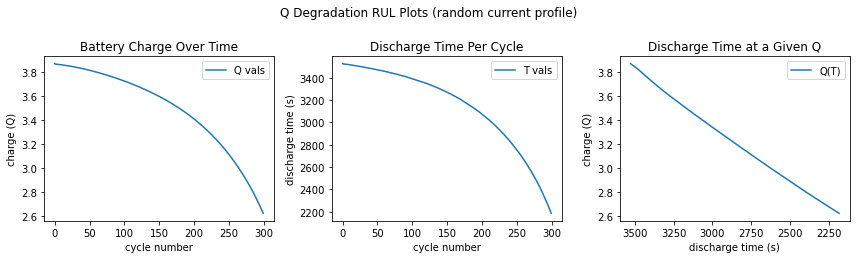

In [143]:
# create the cell
cbcell = ContinuousBatteryCell(**battery_coefficients)

# define some data containers
q_vals = []
t_vals = []
run_num = 1

# simulate until EOL
while(cbcell.age < .9*cbcell.eol):
    cycle_test(cell=cbcell, random_load=False, verbose=1, dt=1.0, run_num=run_num, q_vals=q_vals, t_vals=t_vals)
    run_num += 1

    # plot the results
three_plot(title="Q Degradation RUL Plots (random current profile)", figsize=(12,4), 
           plot1=np.array([np.arange(0, len(q_vals)), np.array(q_vals)]),
           plot2=np.array([np.arange(0, len(t_vals)), np.array(t_vals)]), 
           plot3=np.array([np.array(t_vals), np.array(q_vals)]),
           label1=["Q vals"],
           label2=["T vals"],
           label3=["Q(T)"],
           title1="Battery Charge Over Time",
           title2="Discharge Time Per Cycle",
           title3="Discharge Time at a Given Q",
           axes1=['cycle number', 'charge (Q)'],
           axes2=['cycle number', 'discharge time (s)'],
           axes3=['discharge time (s)', 'charge (Q)'],
           invert = [0,0,1],
           save=False,
           filename="figures/rul_plots_random_load.png")